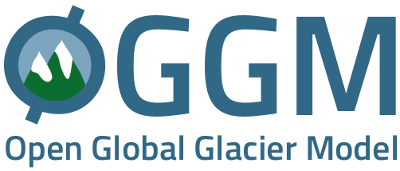

# Working with the RGI files

The glacier outlines obtained from the [Randolph Glacier Inventory](https://www.glims.org/RGI/) are the reference dataset for global and regional applications in OGGM. The current version is V6, and OGGM ships with a slightly modified version which we called `61`.

## Download the glacier outlines 

 To download this version, simply do: 

In [91]:
# this might take a couple of minutes!
from oggm import utils
utils.get_rgi_dir(version='61')  # path to the data after download

'/home/mowglie/disk/OGGM_INPUT/rgi/RGIV61'

## Access a region file

The RGI is divided in 19 regions (and many more sub-regions, not plotted here):

![rgi-map](https://www.researchgate.net/profile/Tobias_Bolch/publication/264125572/figure/fig1/AS:295867740377088@1447551774164/First-order-regions-of-the-RGI-with-glaciers-shown-in-red-Region-numbers-are-those-of.png)
*Source: [the RGI consortium](http://www.glims.org/RGI/randolph60.html)*

In [92]:
from oggm import utils
fr = utils.get_rgi_region_file(11, version='61')  # Central Europe

The RGI region files are [shapefiles](https://en.wikipedia.org/wiki/Shapefile), a vector format commonly used in GIS applications. The library of choice to read shapefiles in python is [geopandas](http://geopandas.org/):

In [93]:
import geopandas as gpd
gdf = gpd.read_file(fr)

## The RGI files and their attributes 

The `gdf` variable is a `GeoDataFrame`, i.e. you can use most of the tools you know from pandas' `DataFrames`:

In [52]:
len(gdf)

3927

In [53]:
gdf.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
0,RGI60-11.00001,G013599E47495N,20030799,20030999,13.5987,47.4949,11,1,0.122,2191,...,461,0,0,0,0,9,9,None,None,"POLYGON ((13.60035015400007 47.49330088800008,..."
1,RGI60-11.00002,G013614E47485N,20030799,20030999,13.6135,47.4845,11,1,2.292,2203,...,1853,0,0,0,0,9,9,None,None,"POLYGON ((13.60638417200005 47.47577712600003,..."
2,RGI60-11.00003,G013596E47484N,20030799,20030999,13.5960,47.4835,11,1,0.851,2280,...,1140,0,0,0,0,9,9,None,None,"POLYGON ((13.59765307300006 47.47612829400003,..."
3,RGI60-11.00004,G013583E47481N,20030799,20030999,13.5829,47.4807,11,1,0.053,2319,...,382,0,0,0,0,9,9,None,None,"POLYGON ((13.58282961100002 47.47969313200008,..."
4,RGI60-11.00005,G013603E47477N,20030799,20030999,13.6026,47.4774,11,1,0.057,2656,...,202,0,0,0,0,9,9,None,None,"POLYGON ((13.60075742500004 47.47519346500007,..."


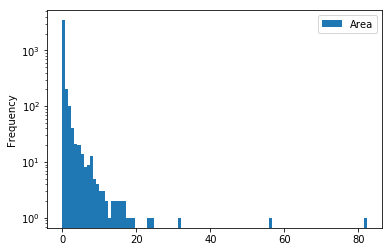

In [65]:
gdf[['Area']].plot(kind='hist', bins=100, logy=True);

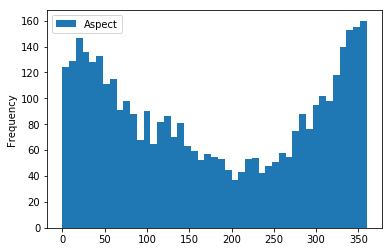

In [71]:
gdf[['Aspect']].plot(kind='hist', bins=45);

## Selecting glaciers per attribute

You may want to select all glaciers in the subregion 2 (Pyrenees):

In [66]:
gdf_sel = gdf.loc[gdf.O2Region == '2']

In [75]:
'Glacier area in the Pyrenees: {} km2'.format(gdf_sel.Area.sum())

'Glacier area in the Pyrenees: 3.183 km2'

## Selecting glaciers in a basin 

Let's use a file shipped with OGGM for a start: 

In [77]:
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

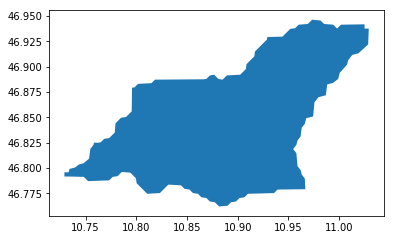

In [78]:
basin.plot();

And select all glaciers within this shape:

In [82]:
import shapely.geometry as shpg
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

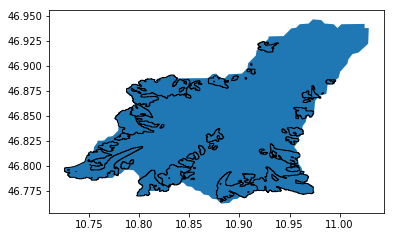

In [85]:
ax = basin.plot();
gdf_sel.plot(ax=ax, edgecolor='k');

## Use the RGI files to start an OGGM run 

RGI files can be given as input to OGGM to make a run:

In [108]:
from oggm import cfg, workflow, tasks
cfg.initialize(logging_level='WORKFLOW')
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['border'] = 10
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Rofental', reset=True)

gdirs = workflow.init_glacier_regions(gdf_sel, from_prepro_level=5)

2019-01-13 20:05:52: oggm.cfg: Using configuration file: /home/mowglie/Documents/git/oggm-fork/oggm/params.cfg
2019-01-13 20:05:52: oggm.workflow: init_glacier_regions from prepro level 5 on 54 glaciers.
2019-01-13 20:05:52: oggm.workflow: Execute entity task _gdirs_from_prepro on 54 glaciers
2019-01-13 20:05:52: oggm.workflow: Multiprocessing: using all available processors (N=8)


In [107]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             y0=2000, output_filesuffix='_2000')
ds2000 = utils.compile_run_output(gdirs, filesuffix='_2000')

2019-01-13 20:04:39: oggm.workflow: Execute entity task run_random_climate on 54 glaciers


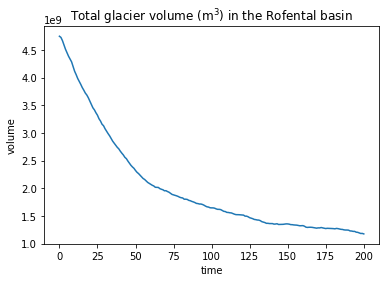

In [110]:
ds2000.sum(dim='rgi_id').volume.plot();
plt.title('Total glacier volume (m$^3$) in the Rofental basin');